In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from google.colab.patches import cv2_imshow
import cv2
import os
import zipfile
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score

In [2]:
!kaggle datasets download -d vipulpisal/fer2013-updated

Dataset URL: https://www.kaggle.com/datasets/vipulpisal/fer2013-updated
License(s): unknown
 80% 41.0M/51.0M [00:01<00:00, 36.2MB/s]
100% 51.0M/51.0M [00:01<00:00, 44.6MB/s]


In [3]:
# Path to the ZIP file containing the FER2013 dataset
zip_file_path = '/content/fer2013-updated.zip'

# Extract the ZIP file
extract_folder = '/content/fer2013.1'  # Choose a folder for extraction
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)


In [4]:
extract_folder = '/content/fer2013.1/FER2013_updated'# Path to the extracted FER2013 dataset

In [5]:
# Define emotion labels and model input shape
emotion_labels = ['angry', 'happy', 'neutral', 'sad', 'surprise']
label_to_int = {label: i for i, label in enumerate(emotion_labels)}

# Define a function to load and preprocess images
def load_and_preprocess_image(image_path):
    img = Image.open(image_path).convert('L').resize((48, 48))  # Convert to grayscale and resize
    img_array = np.array(img) / 255.0  # Normalize pixel values
    return img_array

train_images = []
train_labels = []
train_path = '/content/fer2013.1/FER2013_updated/train'
for emotion_folder in os.listdir(train_path):
    emotion_label = emotion_folder  # Assuming folder name is the emotion label
    emotion_folder_path = os.path.join(train_path, emotion_folder)
    for filename in os.listdir(emotion_folder_path):
        image_path = os.path.join(emotion_folder_path, filename)
        image_array = load_and_preprocess_image(image_path)
        train_images.append(image_array)
        train_labels.append(label_to_int[emotion_label])  # Convert label to integer code

# Convert lists to NumPy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Load and preprocess validation images and labels
validation_images = []
validation_labels = []
validation_path = '/content/fer2013.1/FER2013_updated/validation'
for emotion_folder in os.listdir(validation_path):
    emotion_label = emotion_folder  # Assuming folder name is the emotion label
    emotion_folder_path = os.path.join(validation_path, emotion_folder)
    for filename in os.listdir(emotion_folder_path):
        image_path = os.path.join(emotion_folder_path, filename)
        image_array = load_and_preprocess_image(image_path)
        validation_images.append(image_array)
        validation_labels.append(label_to_int[emotion_label])  # Convert label to integer code

# Convert lists to NumPy arrays
validation_images = np.array(validation_images)
validation_labels = np.array(validation_labels)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Define a function to create and compile multiple models with different initializations
def create_model():
    # Define the CNN model architecture
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),  # Dropout layer with 50% dropout rate
        layers.Dense(len(emotion_labels), activation='softmax') # Number of classes equals the number of emotions
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


# Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define a list to store the trained models
trained_models = []

# Define the number of models to train
num_models = 3

# Train multiple models with different initializations
for _ in range(num_models):
    # Create and compile a new model
    model = create_model()

    # Train the model
    history = model.fit(
        datagen.flow(train_images[..., np.newaxis], train_labels, batch_size=32),
        epochs=20,
        validation_data=(validation_images[..., np.newaxis], validation_labels),
        callbacks=[early_stopping],
        verbose=1  # Set verbose to 0 to avoid printing training progress for each model
    )

    # Add the trained model to the list
    trained_models.append(model)

# Combine predictions from multiple models during inference
def ensemble_predict(models, images):
    predictions = np.zeros((len(images), len(emotion_labels)))
    for model in models:
        predictions += model.predict(images)
    return np.argmax(predictions, axis=1)

# Make predictions using the ensemble of models
ensemble_predictions = ensemble_predict(trained_models, validation_images[..., np.newaxis])

# Calculate accuracy using ensemble predictions
ensemble_accuracy = accuracy_score(validation_labels, ensemble_predictions)
print(f'Ensemble Accuracy: {ensemble_accuracy}')

Epoch 1/20
759/759 [==============================] - 326s 428ms/step - loss: 2.1864 - accuracy: 0.2888 - val_loss: 1.6868 - val_accuracy: 0.3135
Epoch 2/20
759/759 [==============================] - 321s 423ms/step - loss: 1.6019 - accuracy: 0.3093 - val_loss: 1.4067 - val_accuracy: 0.3876
Epoch 3/20
759/759 [==============================] - 334s 440ms/step - loss: 1.5264 - accuracy: 0.3245 - val_loss: 1.3802 - val_accuracy: 0.3950
Epoch 4/20
759/759 [==============================] - 333s 439ms/step - loss: 1.5067 - accuracy: 0.3285 - val_loss: 1.3422 - val_accuracy: 0.4194
Epoch 5/20
759/759 [==============================] - 324s 427ms/step - loss: 1.4720 - accuracy: 0.3564 - val_loss: 1.3706 - val_accuracy: 0.4386
Epoch 6/20
759/759 [==============================] - 319s 420ms/step - loss: 1.4621 - accuracy: 0.3607 - val_loss: 1.2816 - val_accuracy: 0.4922
Epoch 7/20
759/759 [==============================] - 316s 416ms/step - loss: 1.4519 - accuracy: 0.3669 - val_loss: 1.2801 -

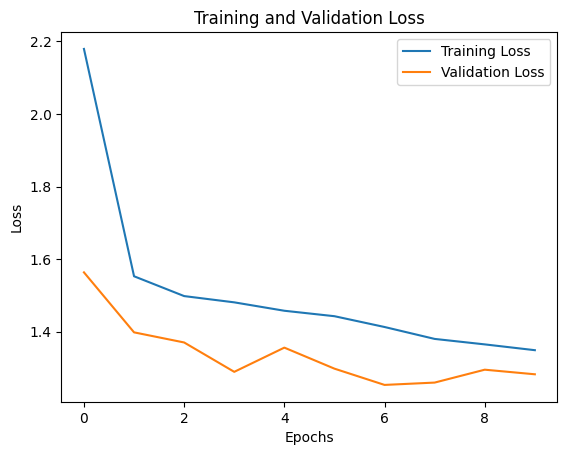

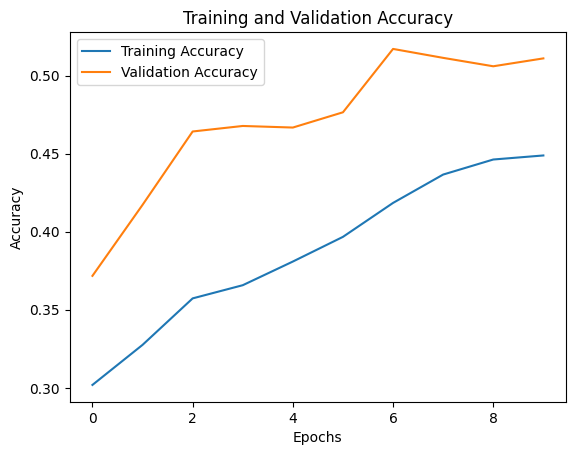

In [6]:
# Visualize training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Visualize training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 0s 27ms/step
PhotoName:sad2.jpg, Predicted Emotion: sad


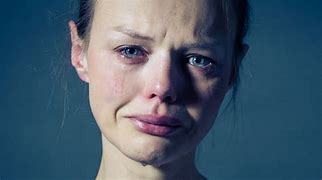

1/1 [==============================] - 0s 23ms/step
PhotoName:surprised2.jpg, Predicted Emotion: sad


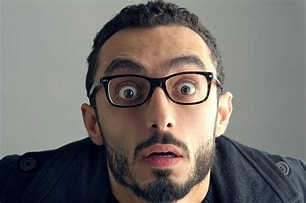

1/1 [==============================] - 0s 24ms/step
PhotoName:happy3.jpg, Predicted Emotion: happy


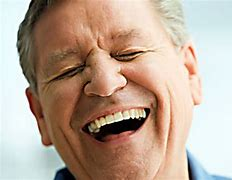

1/1 [==============================] - 0s 24ms/step
PhotoName:neutral2.jpg, Predicted Emotion: sad


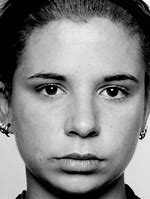

1/1 [==============================] - 0s 23ms/step
PhotoName:happy1.jpg, Predicted Emotion: angry


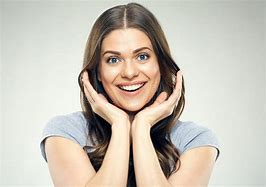

1/1 [==============================] - 0s 24ms/step
PhotoName:happy4.jpg, Predicted Emotion: happy


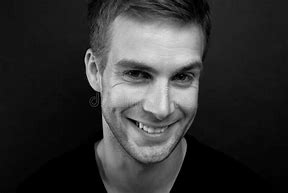

1/1 [==============================] - 0s 24ms/step
PhotoName:happy5.jpg, Predicted Emotion: happy


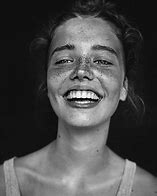

1/1 [==============================] - 0s 24ms/step
PhotoName:sad1.jpg, Predicted Emotion: sad


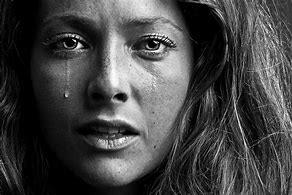

1/1 [==============================] - 0s 25ms/step
PhotoName:sad3.jpg, Predicted Emotion: happy


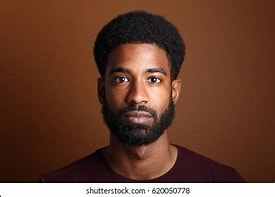

1/1 [==============================] - 0s 42ms/step
PhotoName:happy2.jpg, Predicted Emotion: happy


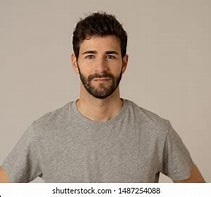

1/1 [==============================] - 0s 22ms/step
PhotoName:angry.jpg, Predicted Emotion: angry


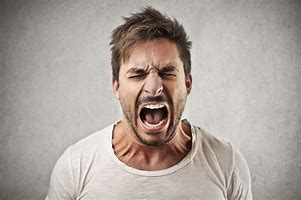

In [7]:
# Define emotion labels
emotion_labels = ['angry', 'happy', 'neutral', 'sad', 'surprise']

# Path to the folder containing multiple input photos
input_photos_folder = '/content/som'

# Loop through each photo in the input folder
for filename in os.listdir(input_photos_folder):
    if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
        # Load and preprocess the input photo
        input_photo_path = os.path.join(input_photos_folder, filename)
        img = image.load_img(input_photo_path, target_size=(48, 48), color_mode='grayscale')
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize pixel values to [0, 1]

        # Make predictions using the model
        predictions = model.predict(img_array)

        # Get the predicted emotion label
        predicted_label = emotion_labels[np.argmax(predictions)]

        # Read the photo using OpenCV
        img_cv = cv2.imread(input_photo_path)

        # Resize the text font size
        text_size = cv2.getTextSize(f'Predicted Emotion: {predicted_label}', cv2.FONT_HERSHEY_SIMPLEX, 1, 2)[0]

        # Display the photo using cv2_imshow() with the predicted emotion label
        print(f'PhotoName:{filename}, Predicted Emotion: {predicted_label}')
        cv2_imshow(img_cv)


In [8]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 batch_normalization_6 (Bat  (None, 46, 46, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_10 (Conv2D)          (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 20, 20, 128)       73856     
                                                                 
 batch_normalization_7 (Bat  (None, 20, 20, 128)      